In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split


time_now=int(time.time())

# Fetching data from the server
url = "https://web-api.coinmarketcap.com/v1/cryptocurrency/ohlcv/historical"

param = {"convert":"USD","slug":"bitcoin","time_end":9999999999,"time_start":"1483228800"}
#1280524800 bitcoin start timestamp
content = requests.get(url=url, params=param).json()
df = pd.json_normalize(content['data']['quotes'])

# Extracting and renaming the important variables
df['Date']=pd.to_datetime(df['quote.USD.timestamp']).dt.tz_localize(None)
df['Low'] = df['quote.USD.low']
df['High'] = df['quote.USD.high']
df['Open'] = df['quote.USD.open']
df['Close'] = df['quote.USD.close']
df['Volume'] = df['quote.USD.volume']

# Drop original and redundant columns
df=df.drop(columns=['time_open','time_close','time_high','time_low', 'quote.USD.low', 'quote.USD.high', 'quote.USD.open', 'quote.USD.close', 'quote.USD.volume', 'quote.USD.market_cap', 'quote.USD.timestamp'])

# Creating a new feature for better representing day-wise values
df['Mean'] = (df['Low'] + df['High'])/2

# Cleaning the data for any NaN or Null fields
df = df.dropna()

# Creating a copy for making small changes
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift()
dataset_for_prediction=dataset_for_prediction.dropna()

# date time typecast
dataset_for_prediction['Date'] =pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index= dataset_for_prediction['Date']

#Normalizing the data
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High', 'Open', 'Close', 'Volume', 'Mean']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X=scaled_input
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Mean'}, inplace=True)

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index

train_size=int(len(df) *0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
print("Original Data")
print(df.head(5))
print("Normalized X")
print(X.head(5))
print("Normalized y")
print(y.head(5))

Original Data
                     Date          Low  ...       Volume         Mean
0 2017-01-02 23:59:59.999   996.702026  ...  222184992.0  1014.046021
1 2017-01-03 23:59:59.999  1021.599976  ...  185168000.0  1032.839966
2 2017-01-04 23:59:59.999  1044.400024  ...  344945984.0  1101.910034
3 2017-01-05 23:59:59.999   910.416992  ...  510199008.0  1050.758484
4 2017-01-06 23:59:59.999   883.943970  ...  351876000.0   965.377014

[5 rows x 7 columns]
Normalized X
                              Low      High  ...    Volume      Mean
Date                                         ...                    
2017-01-03 23:59:59.999  0.004051  0.003248  ...  0.000354  0.003628
2017-01-04 23:59:59.999  0.004398  0.004945  ...  0.000810  0.004664
2017-01-05 23:59:59.999  0.002357  0.005411  ...  0.001281  0.003896
2017-01-06 23:59:59.999  0.001953  0.003288  ...  0.000829  0.002616
2017-01-07 23:59:59.999  0.001033  0.001255  ...  0.000623  0.001126

[5 rows x 6 columns]
Normalized y
             

# **Exploratory Data Analysis**

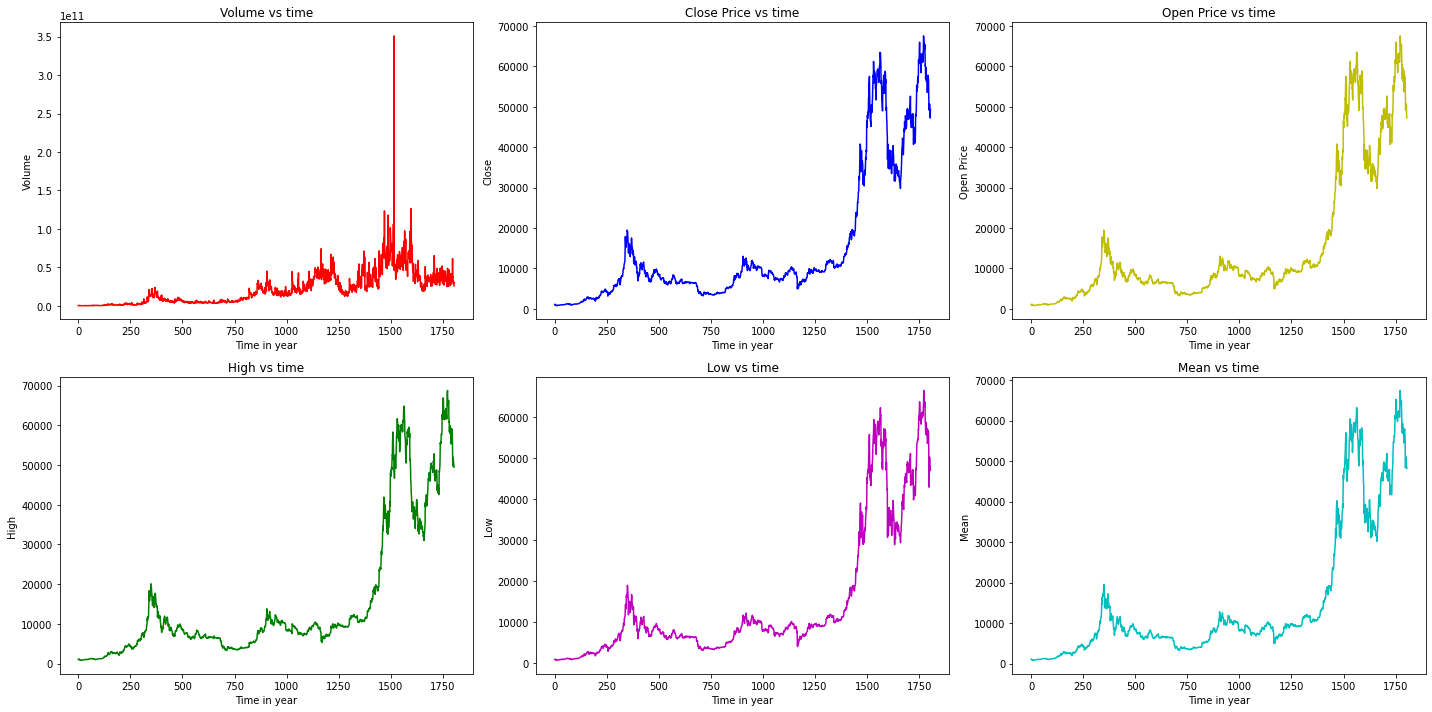

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.plot(df["Volume"], color = "r")
plt.title("Volume vs time")
plt.xlabel("Time in year")
plt.ylabel("Volume")
plt.tight_layout()

plt.subplot(2,3,2)
plt.plot(df["Close"], color = "b")
plt.title("Close Price vs time")
plt.xlabel("Time in year")
plt.ylabel("Close")
plt.tight_layout()

plt.subplot(2,3,3)
plt.plot(df["Open"], color = "y")
plt.title("Open Price vs time")
plt.xlabel("Time in year")
plt.ylabel("Open Price")

plt.subplot(2,3,4)
plt.plot(df["High"], color = "g")
plt.title("High vs time")
plt.xlabel("Time in year")
plt.ylabel("High")
plt.tight_layout()

plt.subplot(2,3,5)
plt.plot(df["Low"], color = "m")
plt.title("Low vs time")
plt.xlabel("Time in year")
plt.ylabel("Low")
plt.tight_layout()

plt.subplot(2,3,6)
plt.plot(df["Mean"], color = "c")
plt.title("Mean vs time")
plt.xlabel("Time in year")
plt.ylabel("Mean")
plt.tight_layout()

plt.tight_layout()

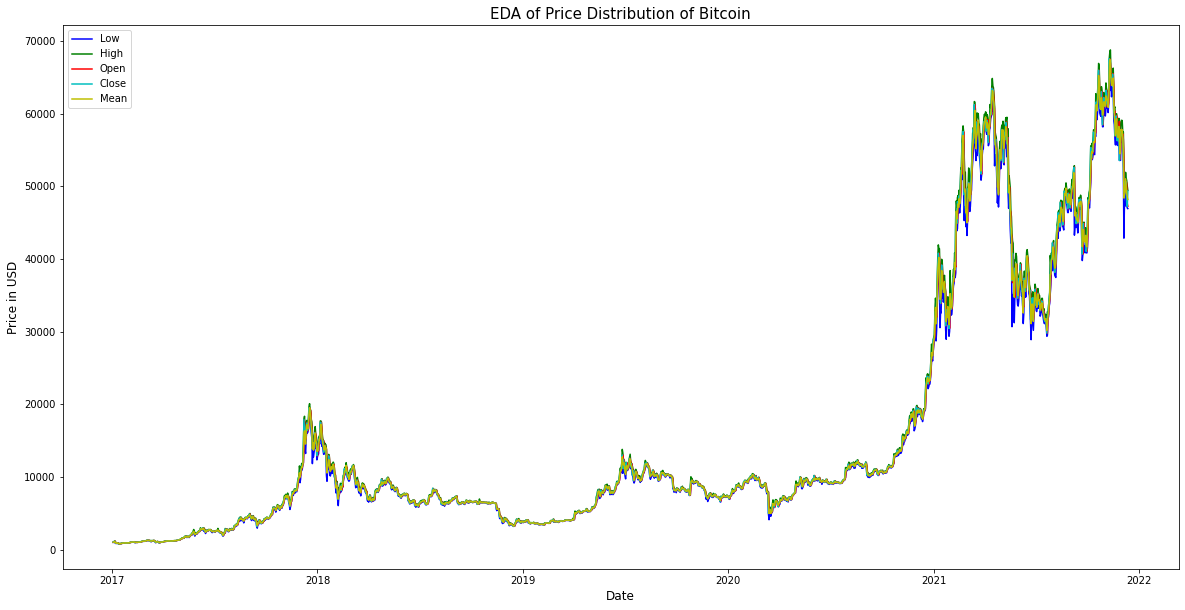

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df['Date'],df['Low'],label='Low', color='b')
plt.plot(df['Date'],df['High'],label='High', color='g')
plt.plot(df['Date'],df['Open'],label='Open', color='r')
plt.plot(df['Date'],df['Close'],label='Close', color='c')
plt.plot(df['Date'],df['Mean'],label='Mean', color='y')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price in USD',fontsize=12)
plt.title('EDA of Price Distribution of Bitcoin',fontsize=15)
plt.legend()
plt.show()

             Low      High      Open     Close    Volume      Mean
Low     1.000000  0.998767  0.998823  0.999228  0.661925  0.999673
High    0.998767  1.000000  0.999398  0.999351  0.675539  0.999710
Open    0.998823  0.999398  1.000000  0.998503  0.671319  0.999427
Close   0.999228  0.999351  0.998503  1.000000  0.669774  0.999599
Volume  0.661925  0.675539  0.671319  0.669774  1.000000  0.669144
Mean    0.999673  0.999710  0.999427  0.999599  0.669144  1.000000


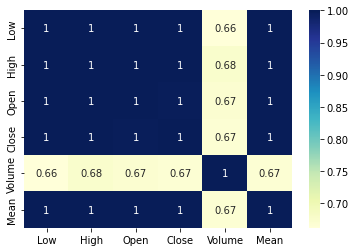

In [ ]:
print(df.corr())
import seaborn as sb
# plotting correlation heatmap
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
dataplot

# **EXTRA TREE REGRESSOR**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error as rmse

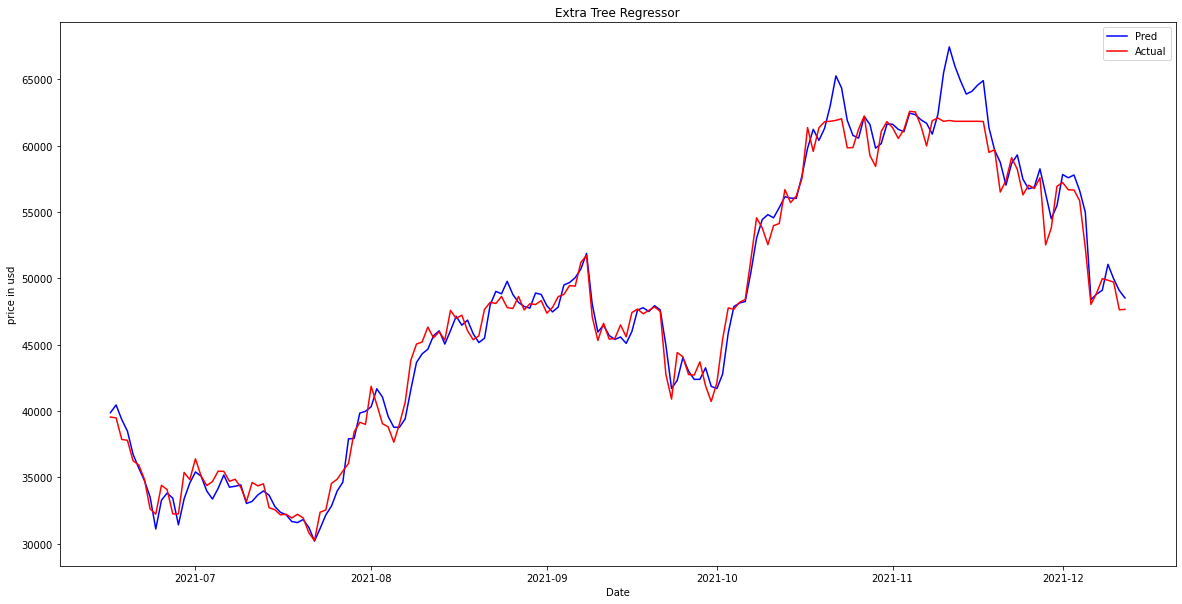

extra tree regressor
model score: 0.9840619233122447
RMSE:[129.34686088]


In [ ]:
etr = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(train_X,train_y)
predictions=etr.predict(test_X)
E=etr.score(test_X, test_y)


# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
Ermse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("Extra Tree Regressor")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("extra tree regressor")
print("model score: "+ str(E))
print("RMSE:"+str(Ermse))

# **GRADIENT BOOSTING MACHINE REGRESSION**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

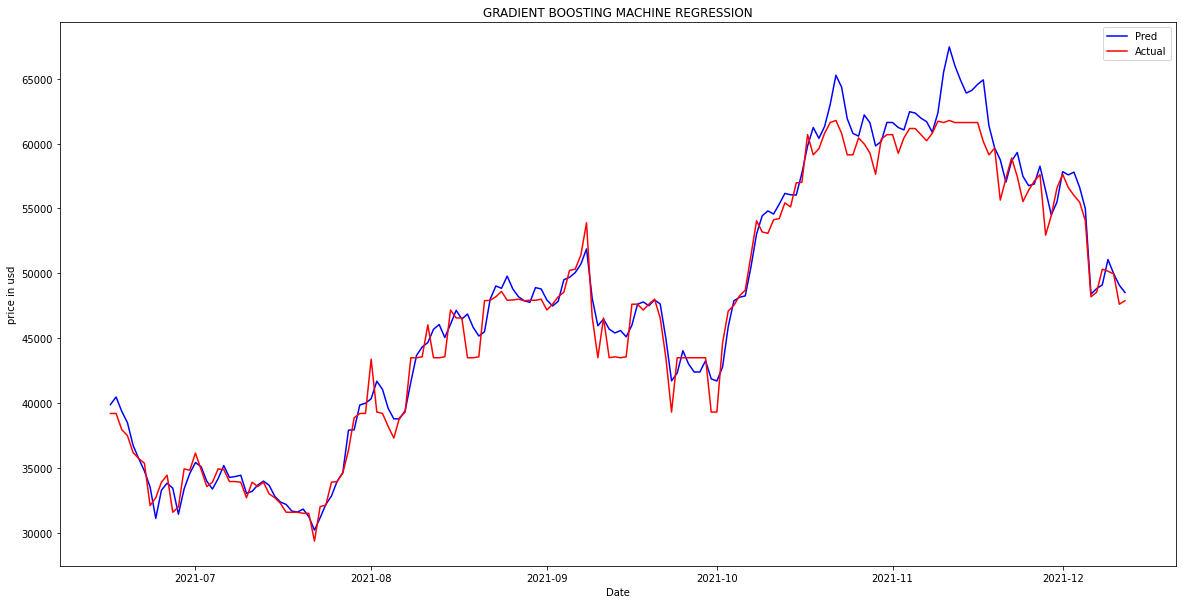

gradient boosting regressor
model score: 0.9779461866802861
RMSE: [152.15274232]


In [ ]:
sbr = GradientBoostingRegressor(random_state=0).fit(train_X,train_y)
predictions=sbr.predict(test_X)
G= sbr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
Grmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("GRADIENT BOOSTING MACHINE REGRESSION")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("gradient boosting regressor")
print("model score: "+ str(G))
print("RMSE:",str(Grmse))

# **RANDOM FOREST REGRESSION**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

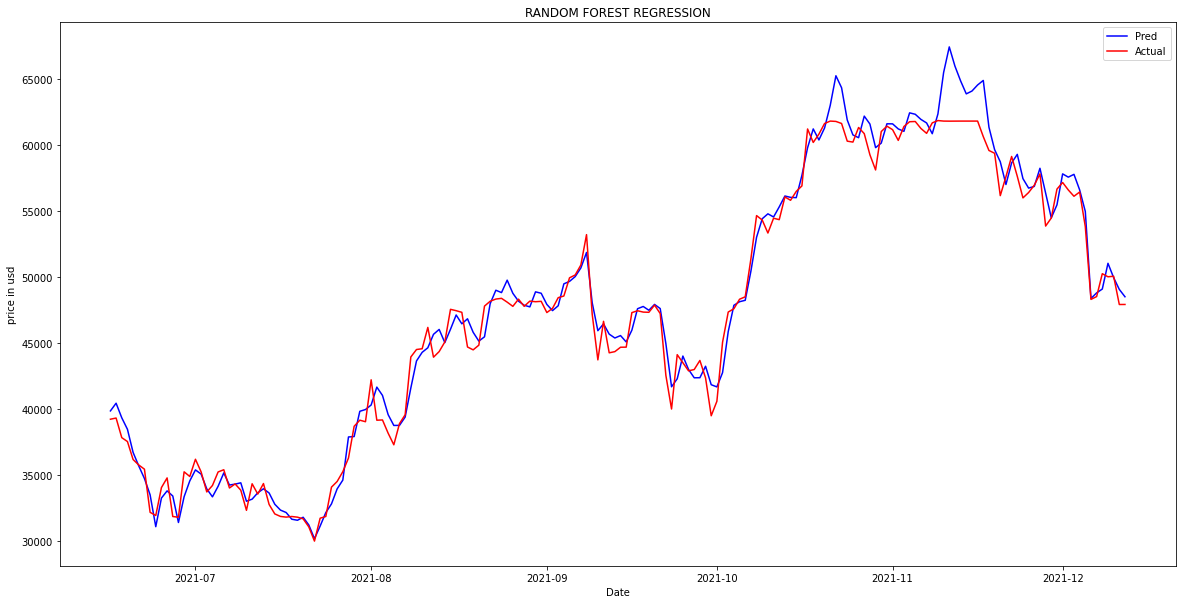

RANDOM FOREST REGRESSION
model score: 0.98320924720966
RMSE:[132.76176607]


In [ ]:
rfr = RandomForestRegressor().fit(train_X,train_y)
predictions=rfr.predict(test_X)
R=rfr.score(test_X, test_y)
# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
rfrrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.title("RANDOM FOREST REGRESSION")
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("RANDOM FOREST REGRESSION")
print("model score: "+ str(R))
print("RMSE:"+str(rfrrmse))

# **DECISION TREE REGRESSION**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

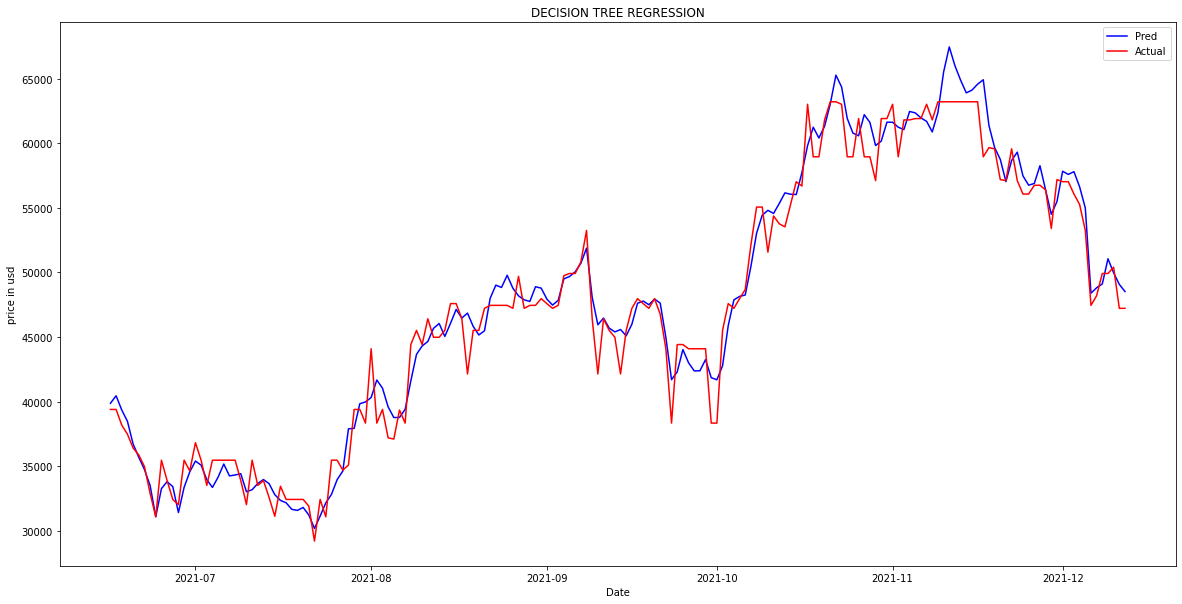

DECISION TREE REGRESSION
model score: 0.9747328695888718
RMSE:[162.86055039]


In [ ]:
dtr = DecisionTreeRegressor().fit(train_X,train_y)
predictions=dtr.predict(test_X)
D=dtr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
drmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("DECISION TREE REGRESSION")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("DECISION TREE REGRESSION")
print("model score: "+ str(D))
print("RMSE:"+str(drmse))

# **LINEAR REGRESSION**

In [ ]:
from sklearn.linear_model import LinearRegression

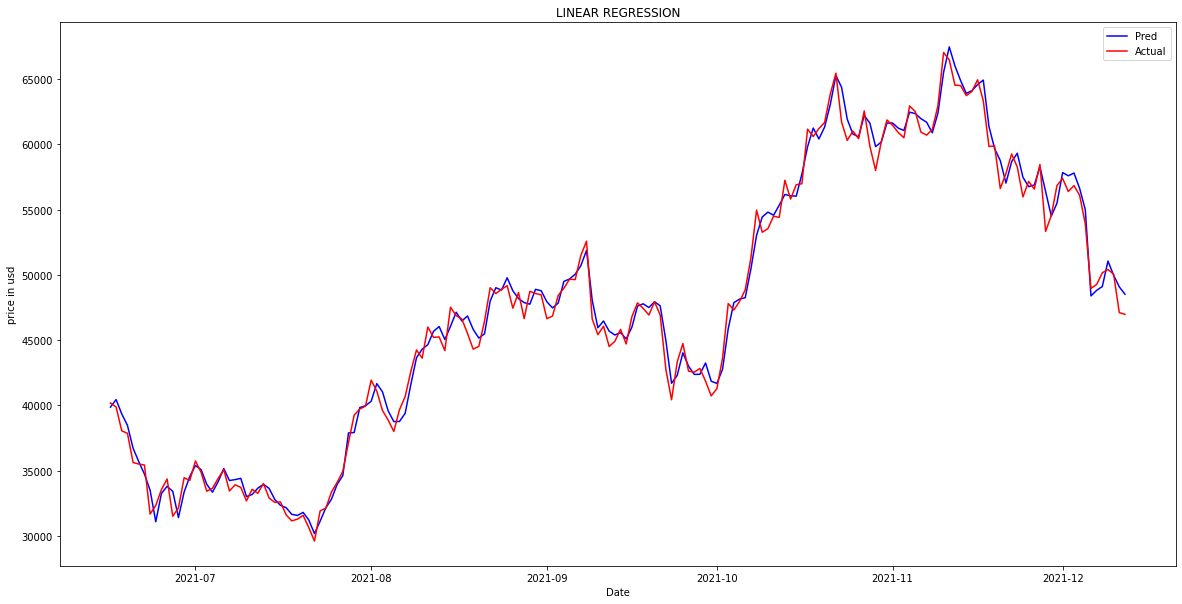

LINEAR REGRESSION
model score: 0.9918191692466187
RMSE: [92.6694619]


In [ ]:
lr = LinearRegression().fit(train_X,train_y)
predictions=lr.predict(test_X)
L=lr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
linrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("LINEAR REGRESSION")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("LINEAR REGRESSION")
print("model score: "+ str(L))
print("RMSE:",str(linrmse))

# **LGBM REGRESSOR**

In [ ]:
from lightgbm import LGBMRegressor

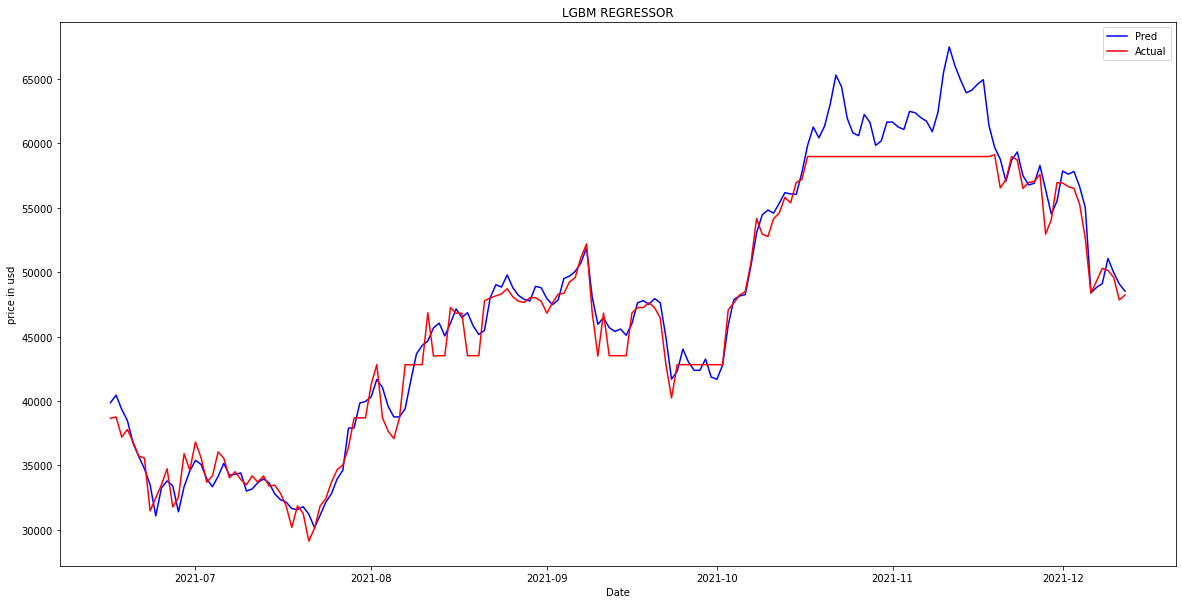

LGBM REGRESSOR
model score: 0.9599145243335282
RMSE:[205.13107593]


In [ ]:
lgbmr = LGBMRegressor().fit(train_X,train_y)
predictions=lgbmr.predict(test_X)
lgbm=lgbmr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
lgbmrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("LGBM REGRESSOR")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("LGBM REGRESSOR")
print("model score: "+ str(lgbm))
print("RMSE:"+str(lgbmrmse))

# **XGBoost REGRESSOR**

In [ ]:
from xgboost.sklearn import XGBRegressor

[12:53:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


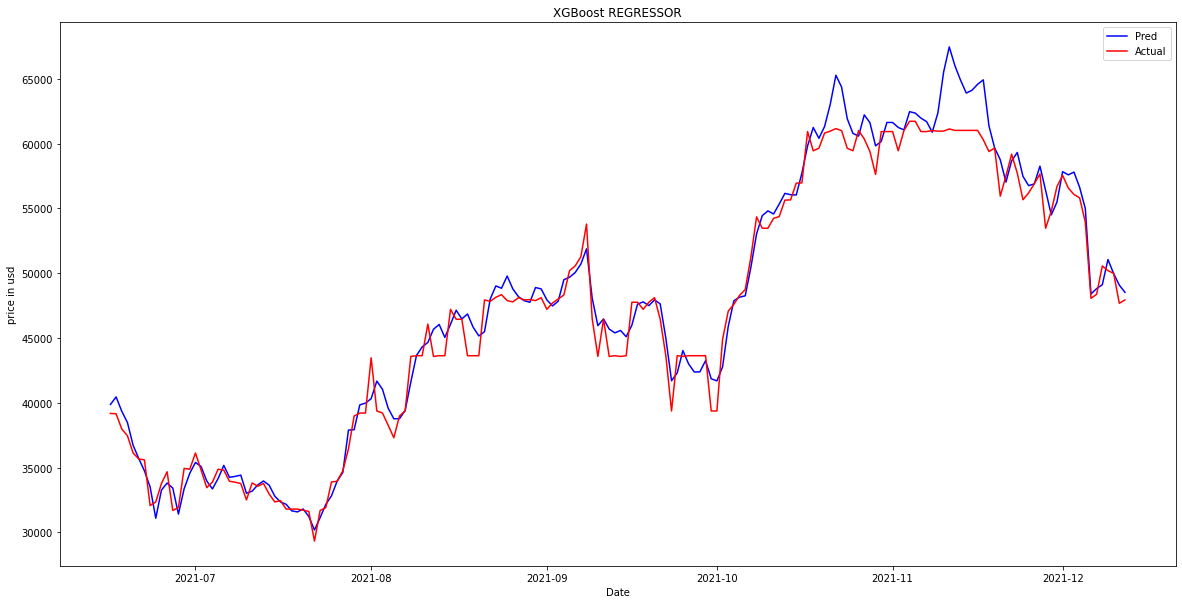

XGBoost regressor
model score 0.9770733885359043
RMSE:[155.13436264]


In [ ]:
xgbr = XGBRegressor().fit(train_X,train_y)
predictions=xgbr.predict(test_X)
X=xgbr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
xgbrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("XGBoost REGRESSOR")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("XGBoost regressor")
print("model score "+ str(X))
print("RMSE:"+str(xgbrmse))

# **Stochastic Gradient Descent Regression**

In [ ]:
from sklearn.linear_model import SGDRegressor

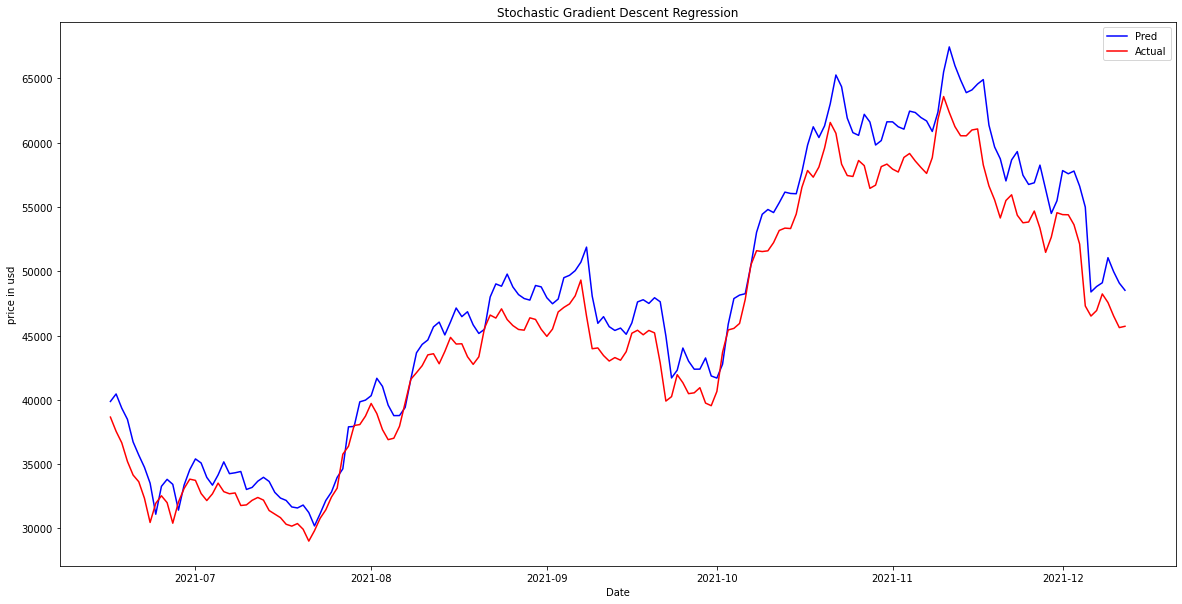

Stochastic Gradient Descent Regression
model score: 0.928129040599384
RMSE:[274.67216985]


In [ ]:
sgdr = SGDRegressor().fit(train_X,train_y)
predictions=sgdr.predict(test_X)
sgd=sgdr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
sgdrrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("Stochastic Gradient Descent Regression")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("Stochastic Gradient Descent Regression")
print("model score: "+ str(sgd))
print("RMSE:"+str(sgdrrmse))

# **Kernel Ridge Regression**

In [ ]:
from sklearn.kernel_ridge import KernelRidge

model score for lgbm regression= 0.9844817636148377


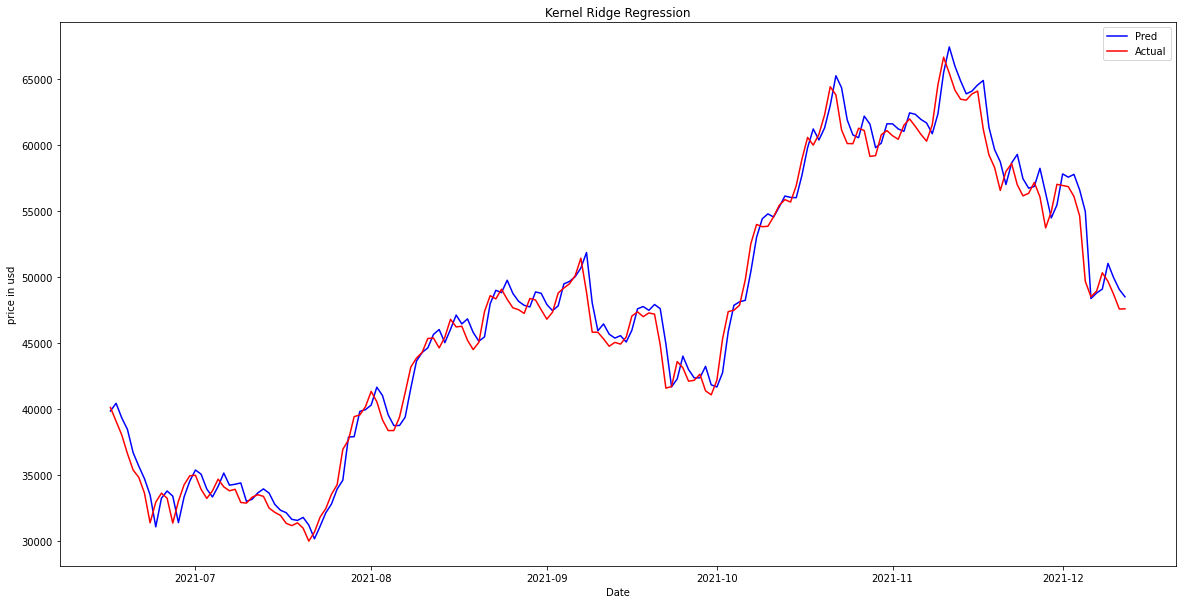

Kernel Ridge Regression
model score: 0.9844817636148377
RMSE:[127.631866]


In [ ]:
krr = KernelRidge().fit(train_X,train_y)
predictions=krr.predict(test_X)
kr=krr.score(test_X, test_y)
print("model score for lgbm regression= "+ str(kr))
# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
krrrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("Kernel Ridge Regression")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("Kernel Ridge Regression")
print("model score: "+ str(kr))
print("RMSE:"+str(krrrmse))

# **Bayesian Ridge Regression**

In [ ]:
from sklearn.linear_model import BayesianRidge

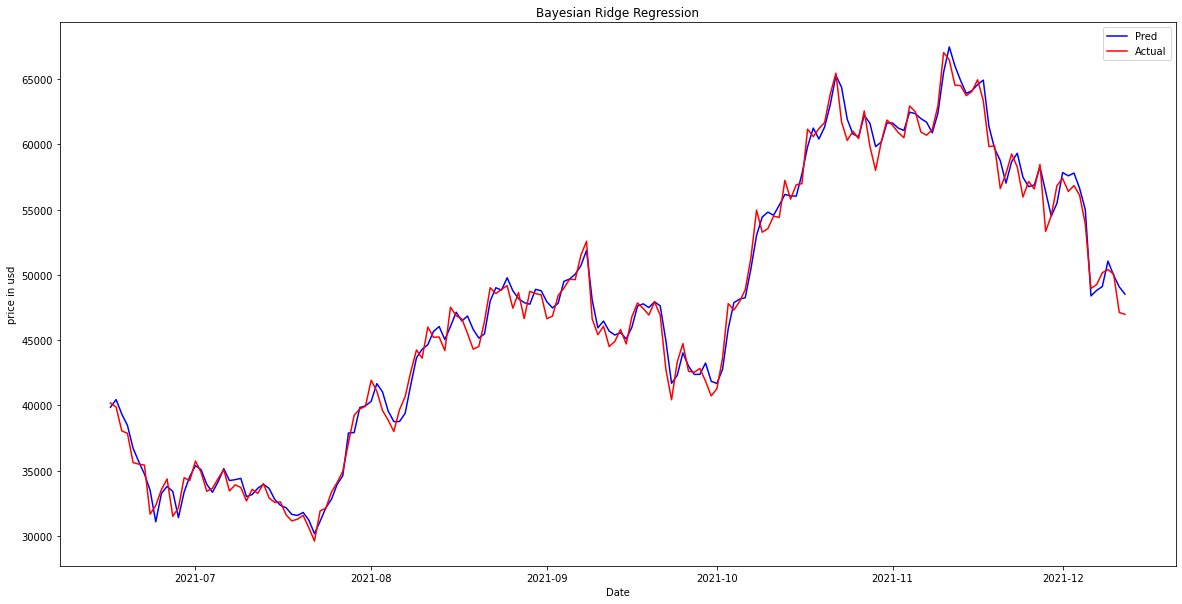

Bayesian Ridge Regression
model score: 0.9918239168659156
RMSE:[92.64256835]


In [ ]:
brr = BayesianRidge().fit(train_X,train_y)
predictions=brr.predict(test_X)
br=brr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
brrrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("Bayesian Ridge Regression")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("Bayesian Ridge Regression")
print("model score: "+ str(br))
print("RMSE:"+str(brrrmse))

# **Support Vector Machine**

In [ ]:
from sklearn.svm import SVR

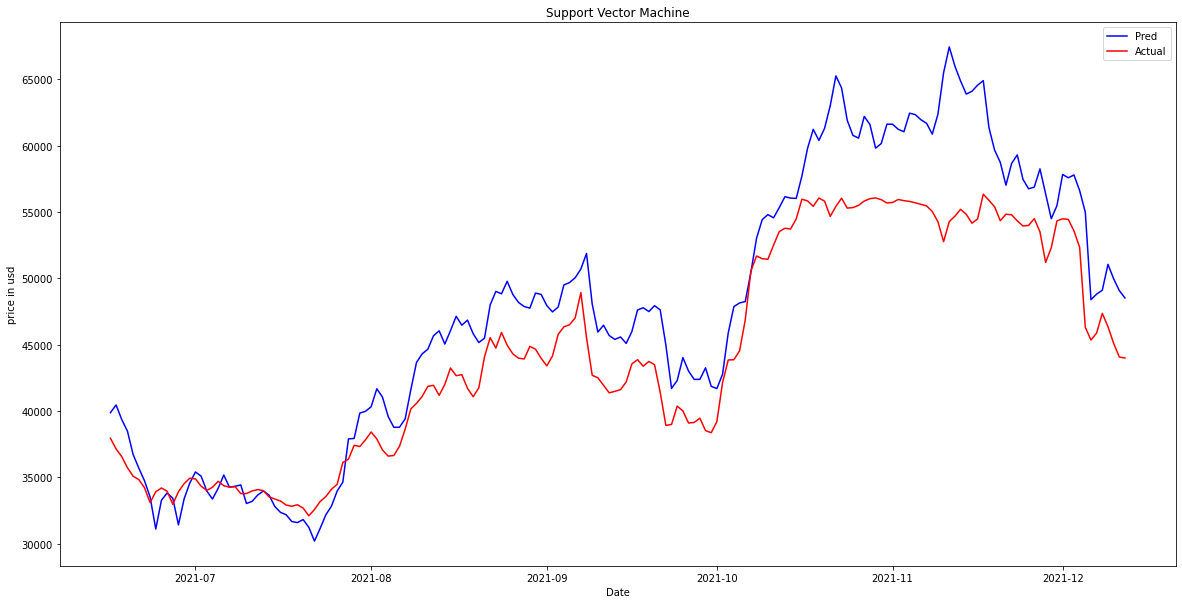

Support Vector Machine
model score: 0.8240662266460115
RMSE:[429.7466955]


In [ ]:
svr = SVR().fit(train_X,train_y)
predictions=svr.predict(test_X)
sv=svr.score(test_X, test_y)

# setting up for plots
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0:'Pred', 'predicted_mean':'Pred'}, inplace=True)


# post-processing inverting normalization
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])
svmrmse=rmse(testActual, testPredict)/10
# prediction plots
plt.figure(figsize=(20,10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.title("Support Vector Machine")
plt.xlabel('Date')
plt.ylabel('price in usd')
plt.legend()
plt.show()

# print RMSE
from statsmodels.tools.eval_measures import rmse
print("Support Vector Machine")
print("model score: "+ str(sv))
print("RMSE:"+str(svmrmse))

# **Comparison Table**

In [ ]:
from prettytable import PrettyTable 
  
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(["Index","Model Name", "Accuracy Score", "RMSE"]) 

myTable.add_row(["1","Extra Tree Regressor", E*100, Ermse]) 
myTable.add_row(["2","Gradient Boosting Machine Regressor", G*100, Grmse]) 
myTable.add_row(["3","Random Forest Regressor", R*100, rfrrmse]) 
myTable.add_row(["4","Decision Tree Regressor", D*100, drmse]) 
myTable.add_row(["5","Linear Regressor", L*100, linrmse]) 
myTable.add_row(["6","LGBM Regressor", lgbm*100, lgbmrmse]) 
myTable.add_row(["7","XGBoost Regressor", X*100, xgbrmse])
myTable.add_row(["8","Stochastic Gradient Decent Regressor", sgd*100, sgdrrmse]) 
myTable.add_row(["9","Kernel Ridge Regressor", kr*100, krrrmse])
myTable.add_row(["10","Bayesian Ridge Regressor", br*100, brrrmse])
myTable.add_row(["11","Support Vector Machine Regressor", sv*100, svmrmse])
  
print(myTable)

+-------+--------------------------------------+-------------------+----------------+
| Index |              Model Name              |   Accuracy Score  |      RMSE      |
+-------+--------------------------------------+-------------------+----------------+
|   1   |         Extra Tree Regressor         | 98.40619233122447 | [129.34686088] |
|   2   | Gradient Boosting Machine Regressor  |  97.7946186680286 | [152.15274232] |
|   3   |       Random Forest Regressor        | 98.32092472096599 | [132.76176607] |
|   4   |       Decision Tree Regressor        | 97.47328695888719 | [162.86055039] |
|   5   |           Linear Regressor           | 99.18191692466188 |  [92.6694619]  |
|   6   |            LGBM Regressor            | 95.99145243335282 | [205.13107593] |
|   7   |          XGBoost Regressor           | 97.70733885359043 | [155.13436264] |
|   8   | Stochastic Gradient Decent Regressor | 92.81290405993839 | [274.67216985] |
|   9   |        Kernel Ridge Regressor        | 98.44